# 1. Load Library

In [25]:
!pip install pyreadstat
!pip install pingouin
!pip install xlsxwriter

In [26]:
from datetime import datetime
import io
import pandas as pd
import pyreadstat
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency,zscore,ttest_1samp,ttest_ind,levene,kstest,mannwhitneyu,ttest_rel,norm,rankdata,kruskal,pearsonr,spearmanr
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd,MultiComparison
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import xlsxwriter
from openpyxl.drawing.image import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Load Scope Spreadsheets

# 3. Read Data SPSS

# 4. Regression Analysis

# 4.1 Simple linear regression

**Input Data**

In [27]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Data Analytics/SPSS Book/Data SPSS/Tqvahq.csv"

# Read the SPSS file
dscp = pd.read_csv(file_path)

**Input Test Value**

In [28]:
# Input Data
table = dscp
x = table['chaohang']
y = table['doanhso']
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

# 4.1.1 Correlation Coefficient
Đo lường mỗi quan hệ giữa 2 hoặc nhiều biến định lượng.

Đo lường mối quan hệ giữa 2 biến doanh số bán hàng (y) và chi phí chào hàng (x). Công ty ghi nhận 12 khu vực trong năm 1996

**Scatter Plot**

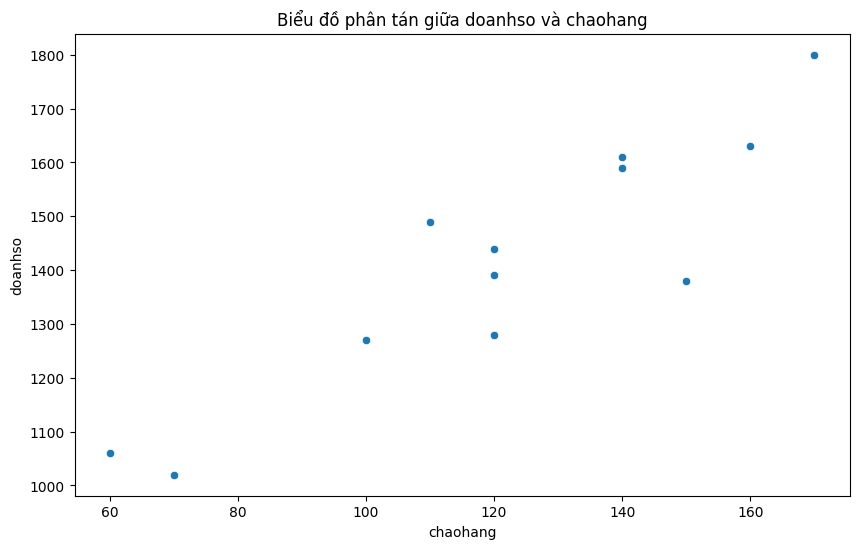

In [29]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=table, x=f'{x.name}', y=f'{y.name}')

# Add labels and title
plt.xlabel(f'{x.name}')
plt.ylabel(f'{y.name}')
plt.title(f'Biểu đồ phân tán giữa {y.name} và {x.name}')

# Save the plot as an image file
plt.savefig(f'scatterplot {y.name} and {x.name}.png')

# Show the plot
plt.show()

**Kolmogorov-Smirnow test to see if the data is normally distributed:**
- If the data is normal distribution, use Pearson Correlation.
- If the data is not normal distribution, use Spearman Correlation.

In [30]:
# Perform the Kolmogorov-Smirnov test for normality on 'x' and 'y'
ks_statistic_x, p_value_x = kstest(x, 'norm', args=(x.mean(), x.std()))
ks_statistic_y, p_value_y = kstest(y, 'norm', args=(y.mean(), y.std()))

# Create the Kolmogorov-Smirnov test results table for 'x'
ks_test_results_x = pd.DataFrame({
  'Variable': ['x'],
  'KS Statistic': [ks_statistic_x],
  'p-value': [p_value_x],
  'alpha': [alpha],
  'Result': ['Reject the null hypothesis (data does not follow normal distribution)' if p_value_x <= alpha else 'Fail to reject the null hypothesis (data follows normal distribution)']
})

# Create the Kolmogorov-Smirnov test results table for 'y'
ks_test_results_y = pd.DataFrame({
  'Variable': ['y'],
  'KS Statistic': [ks_statistic_y],
  'p-value': [p_value_y],
  'alpha': [alpha],
  'Result': ['Reject the null hypothesis (data does not follow normal distribution)' if p_value_y <= alpha else 'Fail to reject the null hypothesis (data follows normal distribution)']
})

# Results for Test
if p_value_x > alpha and p_value_y > alpha:
  result_ks = 'Data follow normal distribution. Chose Pearson Correlation'
  conclusion_ks = pd.DataFrame({
    'Result': [result_ks]
  })
else:
  result_ks = 'Data does not follow normal distribution. Chose Spearman Correlation'
  conclusion_ks = pd.DataFrame({
    'Result': [result_ks]
  })

print('Kolmogorov-Smirnov Test Results for x:')
print(ks_test_results_x)

print('Kolmogorov-Smirnov Test Results for y:')
print(ks_test_results_y)

print('Conclusion:')
print(conclusion_ks)

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_ks_test_results.xlsx') as writer:
  ks_test_results_x.to_excel(writer, sheet_name=f'KS Test Results {x.name}', index=False)
  ks_test_results_y.to_excel(writer, sheet_name=f'KS Test Results {y.name}', index=False)
  conclusion_ks.to_excel(writer, sheet_name='Conclusion', index=False)

print('Read file simple_linear_regression_ks_test_results.xlsx')

Kolmogorov-Smirnov Test Results for x:
  Variable  KS Statistic   p-value  alpha  \
0        x      0.146845  0.925214   0.05   

                                              Result  
0  Fail to reject the null hypothesis (data follo...  
Kolmogorov-Smirnov Test Results for y:
  Variable  KS Statistic   p-value  alpha  \
0        y      0.110075  0.995062   0.05   

                                              Result  
0  Fail to reject the null hypothesis (data follo...  
Conclusion:
                                              Result
0  Data follow normal distribution. Chose Pearson...
Read file simple_linear_regression_ks_test_results.xlsx


**Calculator r (Correlation Coefficient)**
* Pearson - dữ liệu có phân phối chuẩn.
* Spearman - dữ liện không cần phân phối chuẩn.

In [31]:
# Tính hệ số tương quan Pearson
pearson_corr, pearson_p_value = pearsonr(x, y)

# Tạo bảng tương quan Pearson
pearson_corr_df = pd.DataFrame({
  'Variable 1': [f'{x.name}'],
  'Variable 2': [f'{y.name}'],
  'Pearson Correlation': [pearson_corr],
  'p-value': [pearson_p_value]
})
print('Pearson Correlation:')
print(pearson_corr_df)

# Conclusion based on Pearson correlation coefficient
if abs(pearson_corr) >= 0.7:
  correlation_strength = "strong"
elif 0.3 <= abs(pearson_corr) < 0.7:
  correlation_strength = "moderate"
else:
  correlation_strength = "weak"

if pearson_p_value < alpha:
  significance = "significant"
else:
  significance = "not significant"

conclusion_pearson = f"r Pearson: The correlation between {x.name} and {y.name} is {correlation_strength} and {significance}."

print(conclusion_pearson)

# Tính hệ số tương quan Spearman
spearman_corr, spearman_p_value = spearmanr(x, y)

# Tạo bảng tương quan Spearman
spearman_corr_df = pd.DataFrame({
  'Variable 1': [f'{x.name}'],
  'Variable 2': [f'{y.name}'],
  'Spearman Correlation': [spearman_corr],
  'p-value': [spearman_p_value]
})
print('Spearman Correlation:')
print(spearman_corr_df)

# Conclusion based on Spearman correlation coefficient
if abs(spearman_corr) >= 0.7:
  correlation_strength_spearman = "strong"
elif 0.3 <= abs(spearman_corr) < 0.7:
  correlation_strength_spearman = "moderate"
else:
  correlation_strength_spearman = "weak"

if spearman_p_value < alpha:
  significance_spearman = "significant"
else:
  significance_spearman = "not significant"

conclusion_spearman = f"r Spearman: The correlation between {x.name} and {y.name} is {correlation_strength_spearman} and {significance_spearman}."

print(conclusion_spearman)

conclusion = pd.DataFrame({
  'Result Pearson Correlation': [conclusion_pearson],
  'Result Spearman Correlation': [conclusion_spearman],
  'Chose Test Type':[result_ks]
})

print(result_ks)

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_correlation_coefficient_results.xlsx') as writer:
  pearson_corr_df.to_excel(writer, sheet_name='Pearson Correlation', index=False)
  spearman_corr_df.to_excel(writer, sheet_name='Spearman Correlation', index=False)
  conclusion.to_excel(writer, sheet_name='Conclusion', index=False)

  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Bar Plot')

  # Insert the image into the worksheet
  worksheet.insert_image('A1', f'scatterplot {y.name} and {x.name}.png')

print('Read file simple_linear_regression_correlation_coefficient_results.xlsx')

Pearson Correlation:
  Variable 1 Variable 2  Pearson Correlation   p-value
0   chaohang    doanhso             0.904627  0.000053
r Pearson: The correlation between chaohang and doanhso is strong and significant.
Spearman Correlation:
  Variable 1 Variable 2  Spearman Correlation   p-value
0   chaohang    doanhso              0.821901  0.001038
r Spearman: The correlation between chaohang and doanhso is strong and significant.
Data follow normal distribution. Chose Pearson Correlation
Read file simple_linear_regression_correlation_coefficient_results.xlsx


# 4.1.2 Simple linear regression

**Simple linear regression**

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


                            OLS Regression Results                            
Dep. Variable:                doanhso   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     45.05
Date:                Tue, 31 Dec 2024   Prob (F-statistic):           5.29e-05
Time:                        09:08:43   Log-Likelihood:                -71.636
No. Observations:                  12   AIC:                             147.3
Df Residuals:                      10   BIC:                             148.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    651.5229    117.384      5.550      0.0

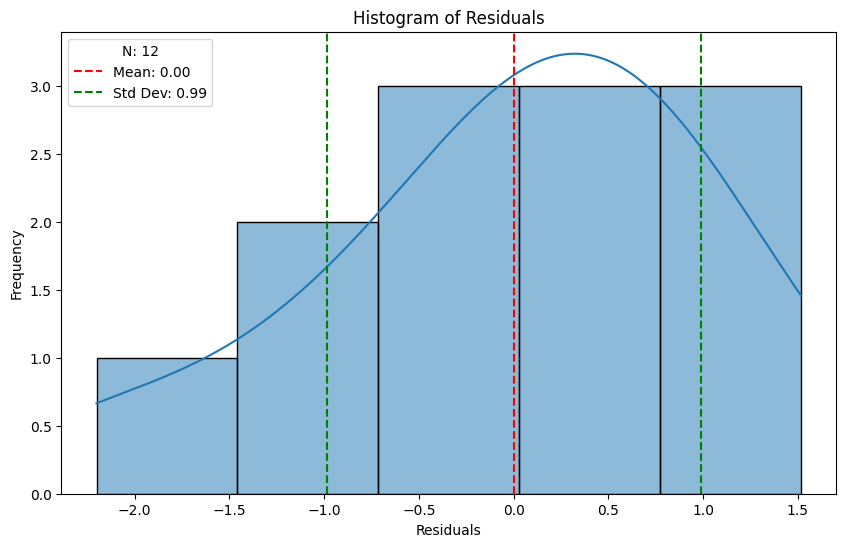

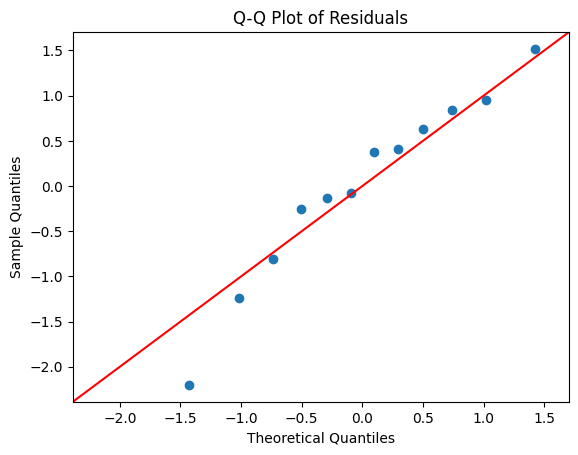

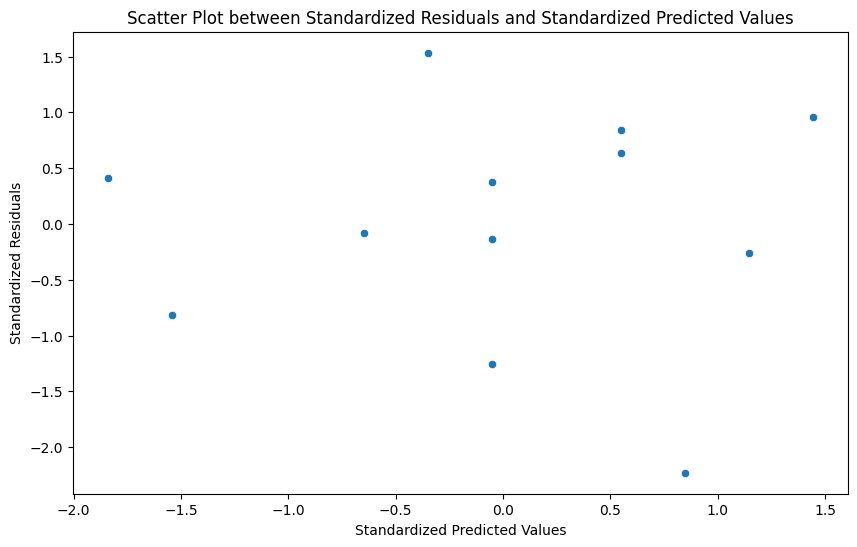

Read file simple_linear_regression_results.xlsx


In [32]:
# Tạo mô hình hồi quy tuyến tính sử dụng công thức
model = smf.ols(f'{y.name} ~ {x.name}', data=table).fit()
print(model.summary())

# Kiểm định Durbin-Watson
residuals = model.resid
residuals_test = abs(residuals)
durbin_watson = sm.stats.stattools.durbin_watson(residuals)

standardized_residuals = model.get_influence().resid_studentized_internal

# Redesign the model_summary table
model_summary = pd.DataFrame({
  'Date': [model.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model.rsquared],
  'Adj. R-squared': [model.rsquared_adj],
  'Durbin Watson': [durbin_watson]
})
print('Model Summary:')
print(model_summary.to_string())

# Bảng ANOVA
anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3')
# Calculate the total sum of squares (SST)
sst = sum((y - y.mean()) ** 2)
# Calculate the residual sum of squares (SSE)
sse = sum(residuals ** 2)
# Calculate the regression sum of squares (SSR)
ssr_regression = sst - sse
# Calculate total sum of squares
ssr_residual = anova_table['sum_sq']['Residual']
# Calculate reression sum of squares
ssr_total = ssr_regression + ssr_residual
# Degrees of freedom
df_residual = model.summary().tables[0][6][1].data
df_regression = model.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model.summary().tables[0][2][3].data, errors='coerce')
anova_p_value = pd.to_numeric(model.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [ssr_regression, ssr_residual, ssr_total],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [anova_p_value, None, None]
})
print('ANOVA table')
print(anova_table)

# Bảng Coefficients
coefficients = model.summary2().tables[1]
print('Coefficients:')
print(coefficients)

# Bảng Correlations - Kiểm định Spearman cho 2 biến x và abs(residuals) (kiểm định giả định phương sai của sai số không đổi)
spearman_corr, spearman_p_value = spearmanr(x, residuals_test)

# Conclusion based on Spearman correlation coefficient
if abs(spearman_corr) >= 0.7:
  correlation_strength_spearman = "strong"
elif 0.3 <= abs(spearman_corr) < 0.7:
  correlation_strength_spearman = "moderate"
else:
  correlation_strength_spearman = "weak"

if spearman_p_value < alpha:
  significance_spearman = "significant"
else:
  significance_spearman = "not significant"

conclusion_spearman = f"r Spearman: The correlation between {x.name} and residuals is {correlation_strength_spearman} and {significance_spearman}."

# Tạo bảng tương quan Spearman
spearman_corr_df = pd.DataFrame({
  'Variable 1': [f'{x.name}'],
  'Variable 2': ['residuals'],
  'Spearman Correlation': [spearman_corr],
  'p-value': [spearman_p_value],
  'Conclusion': [conclusion_spearman]
})

# Kiểm định F - Kiểm tra Sig (p-value) bảng Anova
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print(f"ANOVA p-value: {anova_p_value}, Result: {anova_result}")

# Đánh giá Adj. R-squared
adj_r_squared = model.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print(f"Adjusted R-squared: {adj_r_squared}, Result: {adj_r_squared_result}")

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson < 2.5 else 'Autocorrelation present'
print(f"Durbin-Watson: {durbin_watson}, Result: {durbin_watson_result}")

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients.loc[f'{x.name}','P>|t|']
coefficients_result = 'Independent variable is fit' if coefficients_p_values < alpha else 'Independent variable is not fit'
print(f"p_values Independent variable: {coefficients_p_values}, Result: {coefficients_result}")

hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value}, Result: {anova_result}'],
  'Kiểm định t (student)': [f'Coefficients_p_values: {coefficients_p_values}, Result: {coefficients_result}'],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson}, Result: {durbin_watson_result}'],
  'kiểm định giả định phương sai của sai số không đổi': [conclusion_spearman]
})
print('Hypothsis Test:')
print(hypothesis_test)

# Lấy hệ số từ bảng coefficients
intercept = coefficients.loc['Intercept', 'Coef.']
slope = coefficients.loc[f'{x.name}', 'Coef.']
regression_equation = f'y = {intercept:.2f} + {slope:.2f} * x'
print(regression_equation)

# Viết phương trình hồi quy tuyến tính đơn
regression_equation = pd.DataFrame({
  'Function': [regression_equation]
})
print('Simple Linear Regression')
print(regression_equation)

# Biểu đồ Histogram để khảo sát phân phối của phần dư
# Calculate mean, standard deviation, and sample size
mean_residuals = standardized_residuals.mean()
std_dev_residuals = standardized_residuals.std()
N_residuals = len(standardized_residuals)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
# Add mean, standard deviation, and sample size to the plot
plt.axvline(mean_residuals, color='r', linestyle='--', label=f'Mean: {mean_residuals:.2f}')
plt.axvline(mean_residuals + std_dev_residuals, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals:.2f}')
plt.axvline(mean_residuals - std_dev_residuals, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals}')
plt.savefig('histogram_of_residuals.png')
plt.show()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.savefig('qq_plot_of_residuals.png')
plt.show()

# Standardize the residuals and predicted values
standardized_residuals = (standardized_residuals - standardized_residuals.mean()) / standardized_residuals.std()
standardized_predicted = (model.fittedvalues - model.fittedvalues.mean()) / model.fittedvalues.std()
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=standardized_predicted, y=standardized_residuals)
# Add labels and title
plt.xlabel('Standardized Predicted Values')
plt.ylabel('Standardized Residuals')
plt.title('Scatter Plot between Standardized Residuals and Standardized Predicted Values')
plt.savefig('scatterplot_standardized_residuals_vs_predicted.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('simple_linear_regression_results.xlsx') as writer:
  anova_table.to_excel(writer, sheet_name='ANOVA')
  model_summary.to_excel(writer, sheet_name='Model Summary')
  coefficients.to_excel(writer, sheet_name='Coefficients')
  spearman_corr_df.to_excel(writer, sheet_name='Correlations', index=False)
  regression_equation.to_excel(writer, sheet_name='Function', index=False)
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals.png')
  worksheet.insert_image('A20', 'scatterplot_standardized_residuals_vs_predicted.png')

print('Read file simple_linear_regression_results.xlsx')

**Predict the values using the regression model**

In [33]:
# Predict the values using the regression model
predicted_values = model.predict(table)

# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values

# Display the dataframe with the predicted values
print(table[['chaohang', 'doanhso', 'predicted_values']])

    chaohang  doanhso  predicted_values
0        100     1270       1277.668464
1        110     1490       1340.283019
2         60     1060       1027.210243
3        160     1630       1653.355795
4         70     1020       1089.824798
5        170     1800       1715.970350
6        140     1610       1528.126685
7        120     1280       1402.897574
8        120     1390       1402.897574
9        120     1440       1402.897574
10       140     1590       1528.126685
11       150     1380       1590.741240


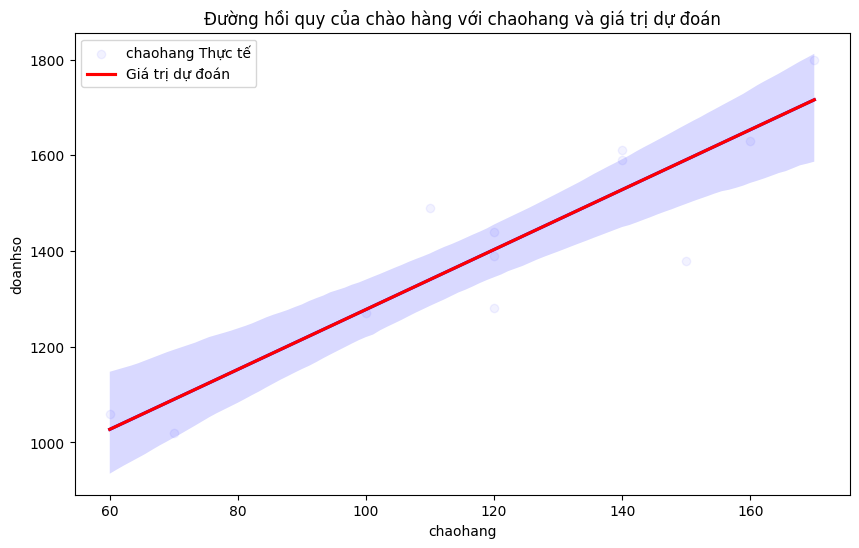

In [34]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x=f'{x.name}', y=f'{y.name}', data=table, label=f'{x.name} Thực tế', scatter_kws={'alpha': alpha}, color='blue')
sns.regplot(x=f'{x.name}', y='predicted_values', data=table, label='Giá trị dự đoán', scatter=False, color='red')

plt.xlabel(f'{x.name}')
plt.ylabel(f'{y.name}')
plt.title(f'Đường hồi quy của chào hàng với {x.name} và giá trị dự đoán')
plt.legend()
plt.show()

**Define the value of x for which you want to predict y**

In [35]:
# Define the value of x for which you want to predict y
x_value = 120

# Create a DataFrame with the new value
new_data = pd.DataFrame({x.name: [x_value]})

# Predict the doanhso value using the regression model
predicted_doanhso = model.predict(new_data)

# Display the predicted value
print(f'Predicted {y.name} for {x.name} = {x_value}: {predicted_doanhso.iloc[0]}')

Predicted doanhso for chaohang = 120: 1402.897574123989


# 4.2 Multiple Linear Regression

**Input Data**

In [36]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Data Analytics/SPSS Book/Data SPSS/Hoi quy boi.csv"

# Read the SPSS file
hqb = pd.read_csv(file_path).drop(columns=['id'])

**Input Test Value**

In [37]:
# Input Data
table = hqb
# Input the dependent variable
dependent_var = 'ttxang'

# Define the independent variables
independent_vars = table.columns.drop(dependent_var).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

# 4.2.1 Correlation Coefficient

Ma trân hệ số tương quan. Đo lường mỗi quan hệ giữa các cặp biến.
- Biến phụ thuộc và độc lập tương quan mạnh - Hồi quy tốt.
- Biến phụ thuộc tương quan với nhau mạnh - Dự đoán khả năng đa cộng tuyến cao.

- Dependent - ttxang (Mức độ tiêu thụ xăng)
- Independent - nang (Trọng lượng xe), maluc (Công suất xe), may (Số máy), lit (Dung tích động cơ của xe)

Read file multiple_linear_regression_correlation_coefficient_results.xlsx


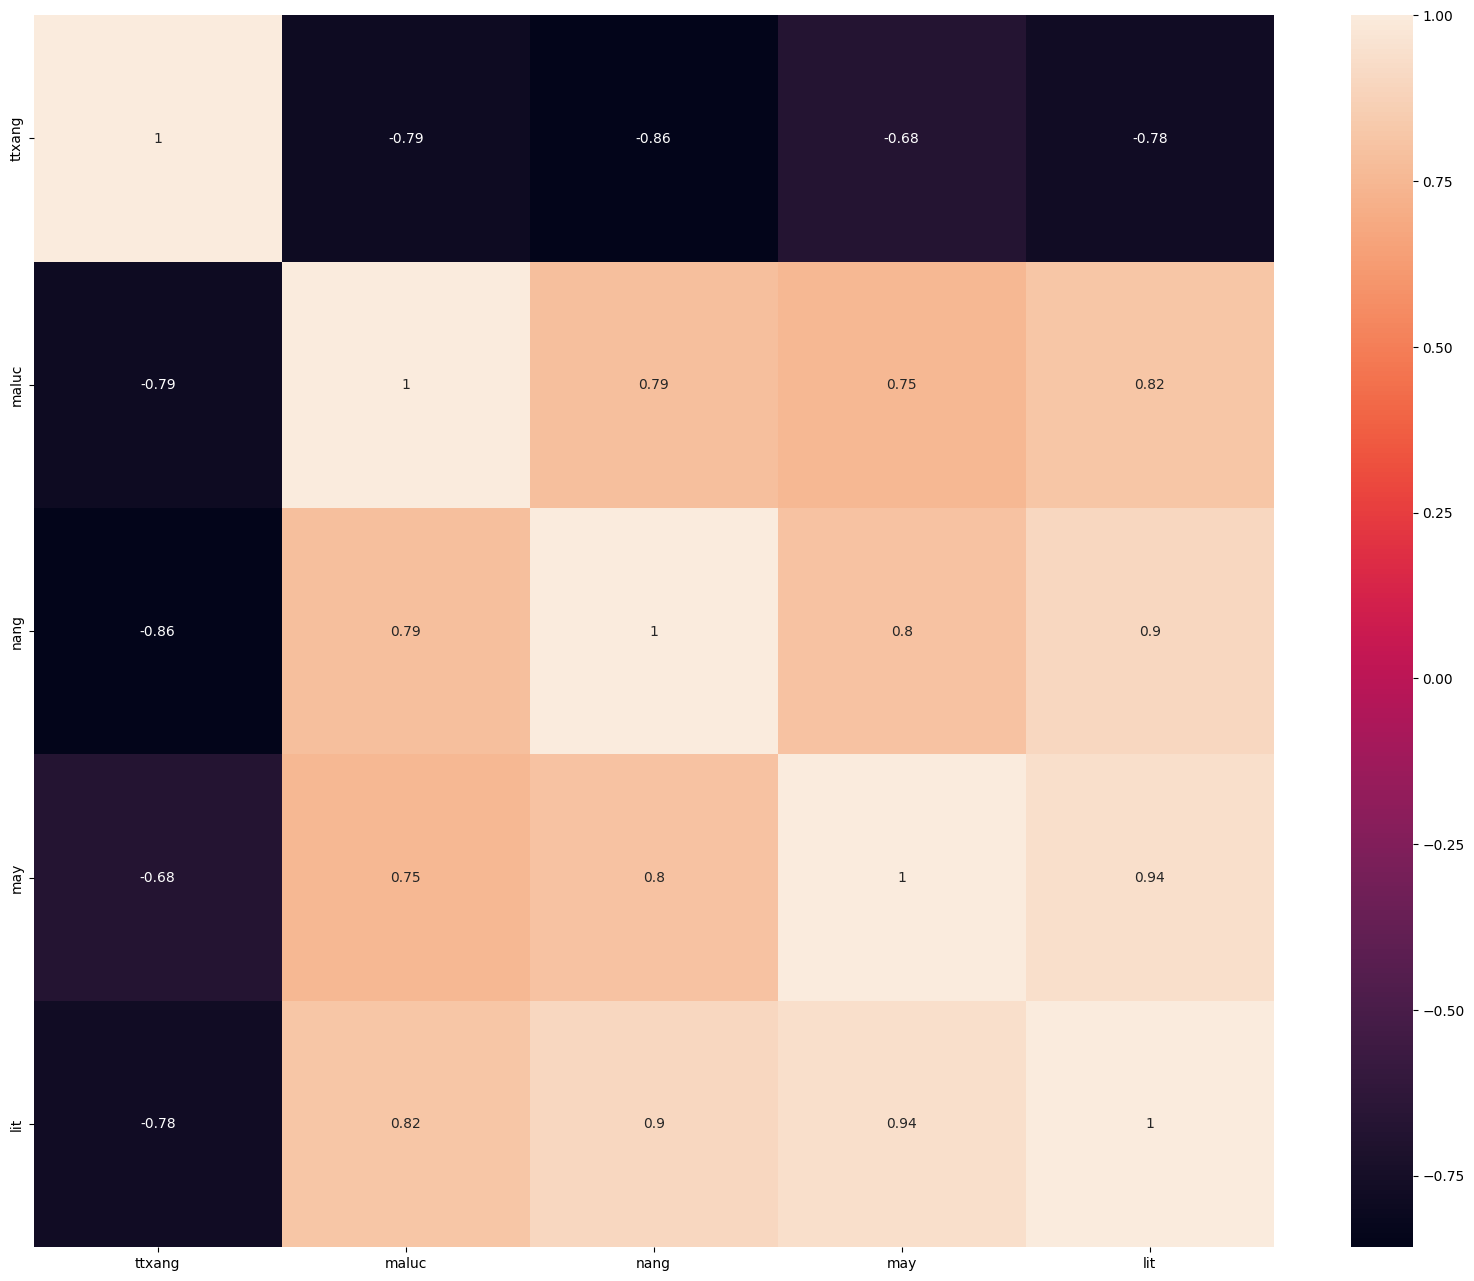

In [38]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('multiple_linear_regression_correlation_coefficient_results.xlsx')

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(20, 16))
sns.heatmap(table.corr(), fmt='.2g', annot=True)

print('Read file multiple_linear_regression_correlation_coefficient_results.xlsx')

# 4.2.2 Multiple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                 ttxang   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     39.08
Date:                Tue, 31 Dec 2024   Prob (F-statistic):           4.23e-14
Time:                        09:09:08   Log-Likelihood:                -96.970
No. Observations:                  50   AIC:                             203.9
Df Residuals:                      45   BIC:                             213.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.2335      2.319     11.312      0.0

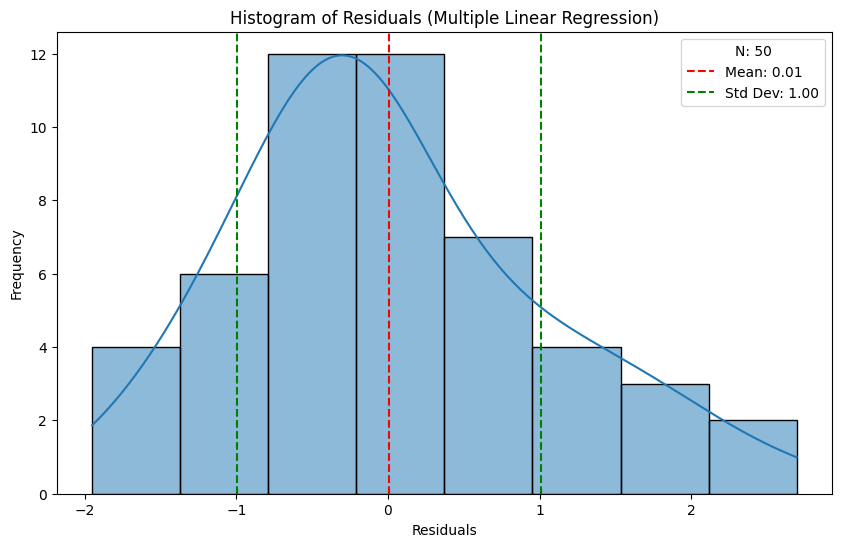

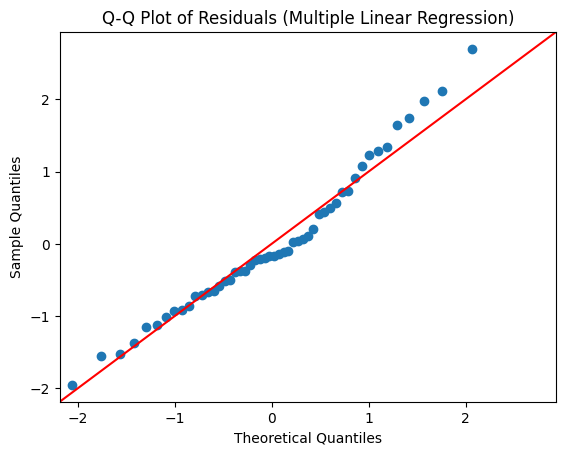

Read file multiple_linear_regression_results.xlsx


In [39]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=table).fit()
print(model_multiple.summary())

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})
print('Model Summary:')
print(model_summary_multiple)

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA table:')
print(anova_table_multiple)

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_multiple)

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
# Kiểm định F - Kiểm tra Sig (p-value) bảng Anova
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria.':
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')
print('Hypothesis Test:')
print(hypothesis_test)

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.2f} * {variable}'

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})
print('Multiple Regression:')
print(regression_equation_df)

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.savefig('histogram_of_residuals_multiple.png')
plt.show()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.savefig('qq_plot_of_residuals_multiple.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('multiple_linear_regression_results.xlsx') as writer:
  correlation_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_multiple.to_excel(writer, sheet_name='Model Summary')
  anova_table_multiple.to_excel(writer, sheet_name='ANOVA')
  coefficients_multiple.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_multiple.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_multiple.png')

print('Read file multiple_linear_regression_results.xlsx')

# 4.2.3 Stepwise Selection
Sử dụng phương pháp chọn từng bước. Đưa vào dần và loại trừ dần để tìm model phù hợp.

In [ ]:
# Define the dependent variable
y = table[dependent_var]

# Define the independent variables
X = table[independent_vars]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Function to calculate VIF
def calculate_vif(X):
  vif = pd.DataFrame()
  vif["Variable"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return vif

# Function to perform stepwise regression
def stepwise_selection(X, y, threshold_in=0.01, threshold_out=0.05):
  initial_features = X.columns.tolist()
  best_features = []
  while True:
    changed = False
    # Forward step
    remaining_features = list(set(initial_features) - set(best_features))
    new_pval = pd.Series(index=remaining_features)
    for new_column in remaining_features:
      model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
      new_pval[new_column] = model.pvalues[new_column]
    best_pval = new_pval.min()
    if best_pval < threshold_in:
      best_features.append(new_pval.idxmin())
      changed = True
    # Backward step
    model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
    pvalues = model.pvalues.iloc[1:]
    worst_pval = pvalues.max()
    if worst_pval > threshold_out:
      changed = True
      worst_feature = pvalues.idxmax()
      best_features.remove(worst_feature)
    if not changed:
      break
  return best_features

# Perform stepwise regression
best_features = stepwise_selection(X, y)

# Fit the final model with the selected features
final_model = sm.OLS(y, sm.add_constant(X[best_features])).fit()

# Print the summary of the final model
print(final_model.summary())

# Calculate VIF for the final model
final_vif = calculate_vif(X[best_features])
print(final_vif)

# Conclusion
if len(independent_vars) == 1:
  conclusion = "The final model does not have multicollinearity issues."
elif final_vif[final_vif['Variable'] != 'const']['VIF'].max() > 10:
  conclusion = "The final model still has multicollinearity issues."
else:
  conclusion = "The final model does not have multicollinearity issues."

print(conclusion)

                            OLS Regression Results                            
Dep. Variable:                 ttxang   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     134.1
Date:                Tue, 31 Dec 2024   Prob (F-statistic):           1.68e-15
Time:                        07:04:16   Log-Likelihood:                -101.09
No. Observations:                  50   AIC:                             206.2
Df Residuals:                      48   BIC:                             210.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8285      1.176     21.965      0.0

# 4.2.4 Optimize Model (if or not)

In [ ]:
# Define the independent variables excluding 'dependent_var', 'may', and 'lit'
independent_vars = [var for var in table.columns if var not in [dependent_var, 'maluc', 'may','lit']] #input dependent remove
print(independent_vars)

table_optimize = table[independent_vars + [dependent_var]]

['nang']


Read file multiple_linear_regression_correlation_coefficient_results_1.xlsx


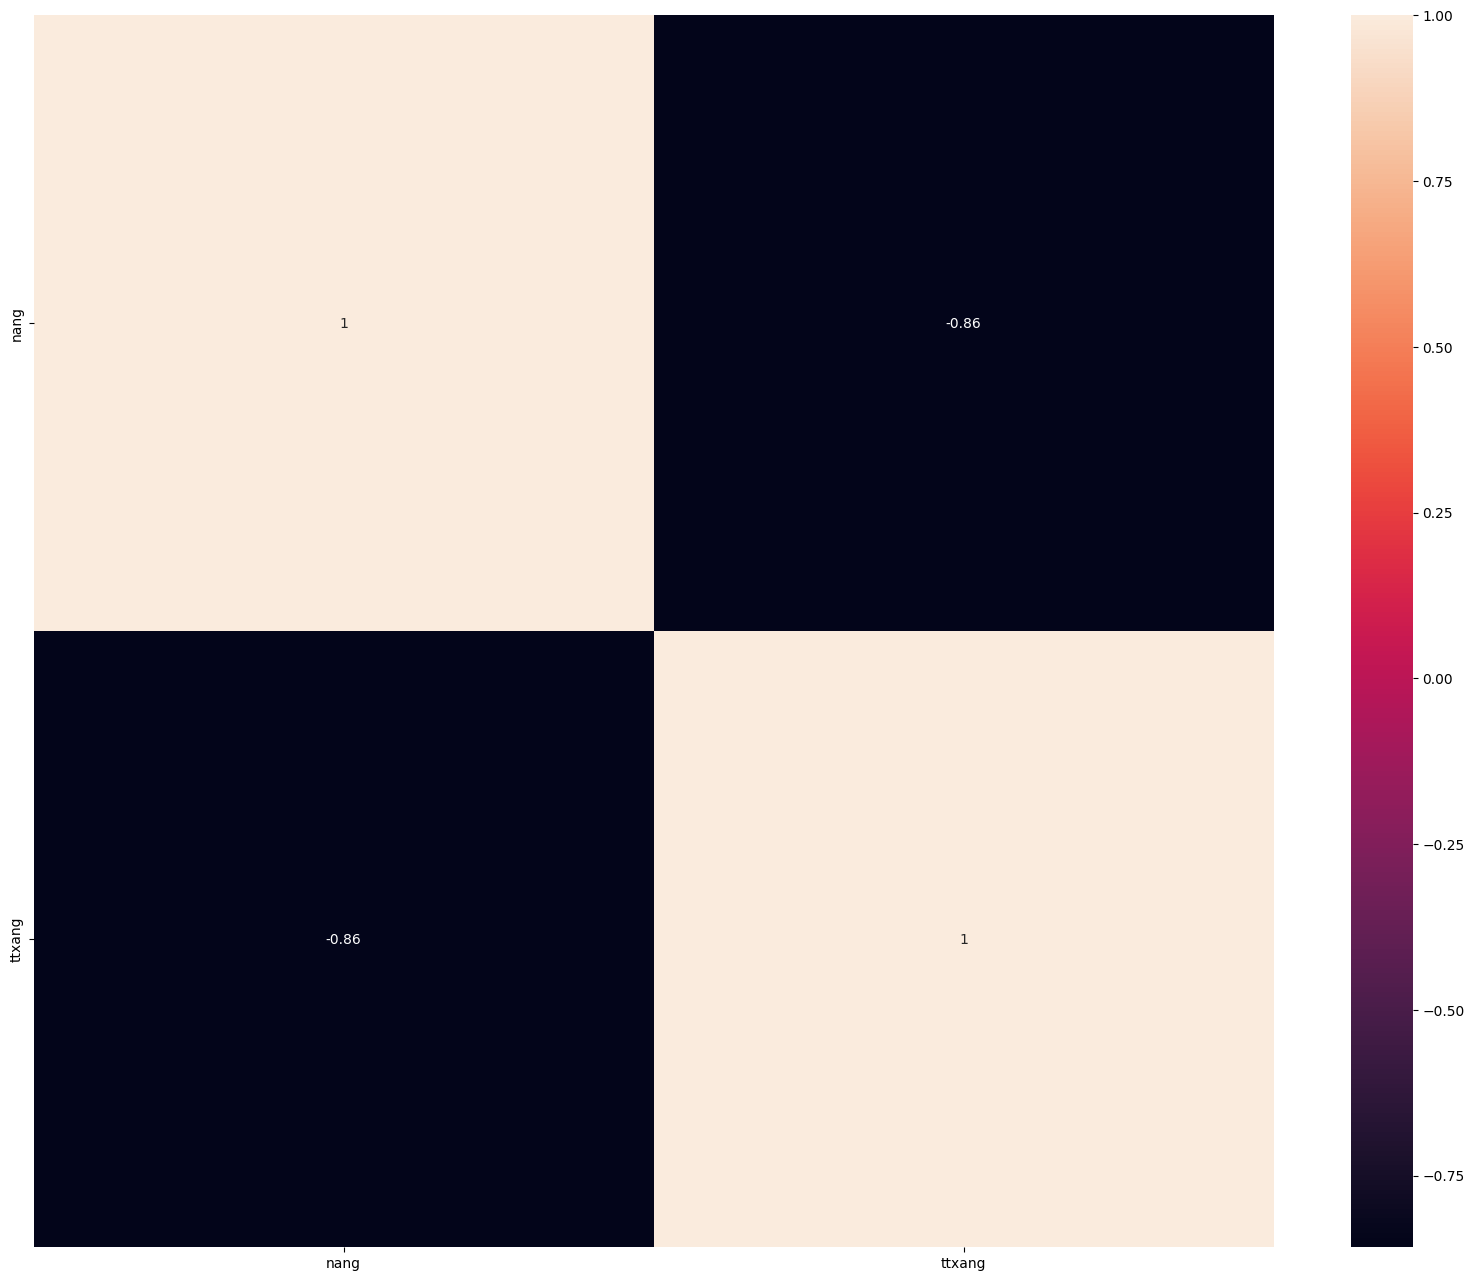

In [ ]:
# Calculate the correlation matrix
correlation_matrix = table_optimize.corr()

# Save the correlation matrix to an Excel file
correlation_matrix.to_excel('multiple_linear_regression_correlation_coefficient_results_1.xlsx')

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(20, 16))
sns.heatmap(table_optimize.corr(), fmt='.2g', annot=True)

print('Read file multiple_linear_regression_correlation_coefficient_results_1.xlsx')

                            OLS Regression Results                            
Dep. Variable:                 ttxang   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     134.1
Date:                Tue, 31 Dec 2024   Prob (F-statistic):           1.68e-15
Time:                        07:04:17   Log-Likelihood:                -101.09
No. Observations:                  50   AIC:                             206.2
Df Residuals:                      48   BIC:                             210.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.8285      1.176     21.965      0.0

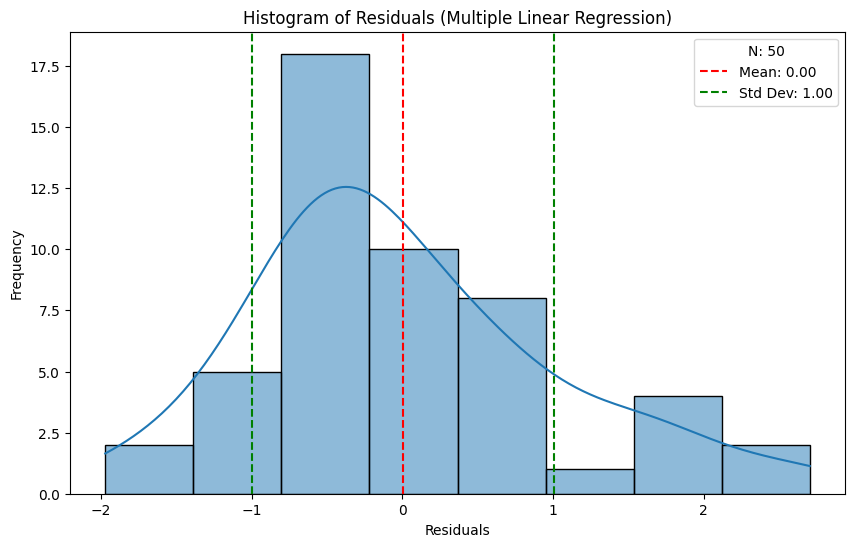

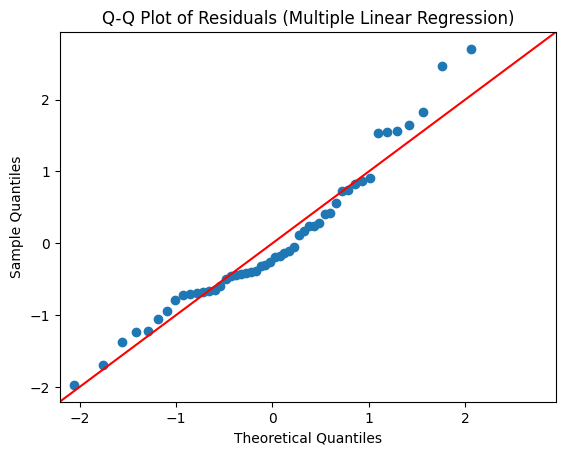

Read file multiple_linear_regression_results_1.xlsx


In [ ]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=table).fit()
print(model_multiple.summary())

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
if len(independent_vars) == 1:
  vif_data == None
else:
  vif_data = pd.DataFrame()
  vif_data["Variable"] = independent_vars
  vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
if len(independent_vars) == 1:
  coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]']]
else:
  coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
# Kiểm định F - Kiểm tra Sig (p-value) bảng Anova
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
if len(independent_vars) == 1:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
else:
  multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
  if not multicollinearity_vars.empty:
    multicollinearity_result = "There is a possibility of multicollinearity"
  else:
    multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria':
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.2f} * {variable}'

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.savefig('histogram_of_residuals_multiple_1.png')
plt.show()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.savefig('qq_plot_of_residuals_multiple_1.png')
plt.show()

# Lưu kết quả vào file Excel
with pd.ExcelWriter('multiple_linear_regression_results_1.xlsx') as writer:
  correlation_matrix.to_excel(writer, sheet_name='Corr Matrix')
  model_summary_multiple.to_excel(writer, sheet_name='Model Summary')
  anova_table_multiple.to_excel(writer, sheet_name='ANOVA')
  coefficients_multiple.to_excel(writer, sheet_name='Coefficients')
  hypothesis_test.to_excel(writer, sheet_name='Hypothesis Test', index=False)
  regression_equation_df.to_excel(writer, sheet_name='Regression Equation', index=False)
  # Access the XlsxWriter workbook and worksheet objects
  workbook  = writer.book
  worksheet = workbook.add_worksheet('Residuals Plots')

  # Insert the images into the worksheet
  worksheet.insert_image('A1', 'histogram_of_residuals_multiple_1.png')
  worksheet.insert_image('A10', 'qq_plot_of_residuals_multiple_1.png')

print('Read file multiple_linear_regression_results_1.xlsx')

**Predict the values using the regression model**

In [ ]:
# Predict the values using the regression model
predicted_values = model_multiple.predict(table_optimize)

# Add the predicted values to the dataframe
table_optimize['predicted_ttxang'] = predicted_values

# Display the dataframe with the predicted values
print(table_optimize[['nang', 'ttxang', 'predicted_ttxang']])

    nang  ttxang  predicted_ttxang
0    893  18.964         16.176661
1   1514   8.756          9.464717
2   1591   8.448          8.632479
3   1550   7.788          9.075619
4   1442   7.964         10.242914
5   1274   8.932         12.058705
6   1460   9.460         10.048364
7   1962   7.436          4.622607
8   1824   6.820          6.114150
9   1773   8.140          6.665372
10  1436  11.968         10.307763
11   965  18.260         15.398464
12   950  20.504         15.560589
13  1089  10.428         14.058237
14  1121  11.968         13.712372
15   790  17.204         17.289914
16  1172  12.320         13.161150
17  1289  10.560         11.896581
18  1607   8.888          8.459547
19  1420   9.020         10.480696
20  1205  12.320         12.804477
21   997  15.268         15.052599
22   810  15.884         17.073748
23   862  15.708         16.511717
24  1334   8.888         11.410208
25  1539  10.516          9.194510
26  1071  13.156         14.252786
27  1463  13.376    

<ipython-input-23-d140662e9202>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_optimize['predicted_ttxang'] = predicted_values


**Define the value of x for which you want to predict y**

In [ ]:
# Define the value of x for which you want to predict y
x_value = 1500

# Create a DataFrame with the new value
new_data = pd.DataFrame({variable: [x_value]})

# Predict the ttxang value using the regression model
predicted_ttxang = model_multiple.predict(new_data)

# Display the predicted value
print(f'Predicted {dependent_var} for {variable} = {x_value}: {predicted_ttxang.iloc[0]}')

Predicted ttxang for nang = 1500: 9.616033132759302
